In [38]:
import xarray as xr
import matplotlib.pyplot as plt

ds = xr.open_dataset("test_era5_t2m_20250101_0000.nc")

print(ds)

# Variable de température = t2m
var_name = "t2m"

# Sélectionner le premier instant (dim = valid_time)
da = ds[var_name].isel(valid_time=0)



<xarray.Dataset> Size: 12kB
Dimensions:     (valid_time: 1, latitude: 43, longitude: 62)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 8B 2025-01-01
  * latitude    (latitude) float64 344B 51.5 51.25 51.0 ... 41.5 41.25 41.0
  * longitude   (longitude) float64 496B -5.5 -5.25 -5.0 -4.75 ... 9.25 9.5 9.75
    expver      <U4 16B ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 11kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-06T13:08 GRIB to CDM+CF via cfgrib-0.9.1...


In [39]:
# Convertir en °C (Kelvin)
if hasattr(ds[var_name], "units") and ds[var_name].units in ["K", "kelvin"]:
    da = da - 273.15
    units = "°C"
else:
    units = getattr(ds[var_name], "units", "")

print(ds[var_name])


<xarray.DataArray 't2m' (valid_time: 1, latitude: 43, longitude: 62)> Size: 11kB
[2666 values with dtype=float32]
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 8B 2025-01-01
  * latitude    (latitude) float64 344B 51.5 51.25 51.0 ... 41.5 41.25 41.0
  * longitude   (longitude) float64 496B -5.5 -5.25 -5.0 -4.75 ... 9.25 9.5 9.75
    expver      <U4 16B ...
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      2666
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_na

In [45]:
print(da)

<xarray.DataArray 't2m' (latitude: 43, longitude: 62)> Size: 11kB
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [      nan,       nan,       nan, ..., 11.31485 , 11.812897,
        13.639069],
       [      nan,       nan,       nan, ..., 10.961334,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], shape=(43, 62), dtype=float32)
Coordinates:
    number      int64 8B ...
    valid_time  datetime64[ns] 8B 2025-01-01
  * latitude    (latitude) float64 344B 51.5 51.25 51.0 ... 41.5 41.25 41.0
  * longitude   (longitude) float64 496B -5.5 -5.25 -5.0 -4.75 ... 9.25 9.5 9.75
    expver      <U4 16B ...


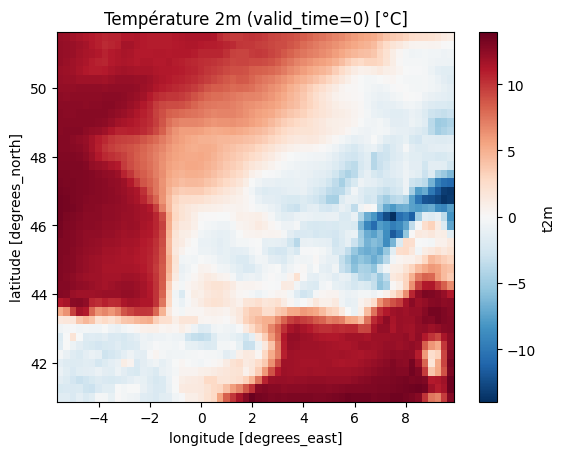

In [40]:
plt.figure()
da.plot()
plt.title(f"Température 2m (valid_time=0) [{units}]")
plt.show()

In [41]:
import geopandas as gdp
import numpy as np
from shapely.geometry import Point



/var/folders/0f/_fg7x2451bj2lywhltbl4j3w0000gn/T/ipykernel_43454/1916913732.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  france_poly = gdf.unary_union


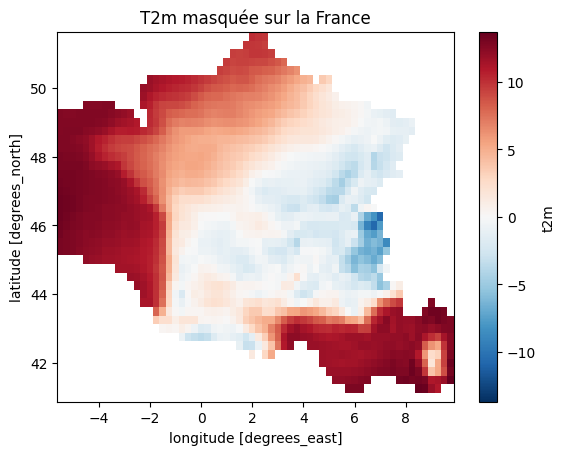

In [ ]:
lats = ds["latitude"].values   # shape (43,)
lons = ds["longitude"].values  # shape (62,)

france = gdp.read_file("masque/fr_1km.shx")


# S'assurer qu'on est en WGS84 (lat/lon degrees)
gdf = france.to_crs("EPSG:4326")

# Union de tous les polygones France (métropole + éventuels DOM)
france_poly = gdf.unary_union

# 3. Construire la grille des points centres des pixels
lon2d, lat2d = np.meshgrid(lons, lats)  # lon: axe x, lat: axe y

# Aplatir pour tester en bloc
points = [Point(x, y) for x, y in zip(lon2d.ravel(), lat2d.ravel())]

# 4. Test point-in-polygon pour chaque point
mask_flat = np.array([france_poly.contains(p) for p in points])
mask = mask_flat.reshape(lat2d.shape)  # shape (latitude, longitude)

# 5. Appliquer le masque à la température
t2m = ds["t2m"]  # (valid_time, latitude, longitude)
t2m_fr = t2m.where(mask)

da = t2m_fr.isel(valid_time=0)
if hasattr(ds[var_name], "units") and ds[var_name].units in ["K", "kelvin"]:
    da = da - 273.15
    units = "°C"
else:
    units = getattr(ds[var_name], "units", "")
plt.figure()
da.plot()
plt.title("T2m masquée sur la France")
plt.show()